In [19]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from scipy.optimize import least_squares
from scipy.interpolate import splprep, splev
from scipy.spatial import distance
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from scipy import ndimage
from scipy.spatial.distance import cdist
from skimage.morphology import label

In [20]:
def plot(image: np.ndarray, title: str=None, zlimit: bool=True, figsize: tuple=(8, 8), **kwargs) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

[Fri, 24 Mar 2023 14:05:43] [INFO    ] [topostats] Extracting image from Irregular/20230118_KPN001_25mMMgCl2_Vac(2).0_00011.spm
[Fri, 24 Mar 2023 14:05:43] [INFO    ] [topostats] Loading image from : Irregular/20230118_KPN001_25mMMgCl2_Vac(2).0_00011.spm
[Fri, 24 Mar 2023 14:05:43] [INFO    ] [topostats] [20230118_KPN001_25mMMgCl2_Vac(2).0_00011] : Loaded image from : Irregular/20230118_KPN001_25mMMgCl2_Vac(2).0_00011.spm
[Fri, 24 Mar 2023 14:05:43] [INFO    ] [topostats] [20230118_KPN001_25mMMgCl2_Vac(2).0_00011] : Extracted channel Height
[Fri, 24 Mar 2023 14:05:43] [INFO    ] [topostats] [20230118_KPN001_25mMMgCl2_Vac(2).0_00011] : Pixel to nm scaling : 12.69013671875
[Fri, 24 Mar 2023 14:05:43] [INFO    ] [topostats] [Irregular/20230118_KPN001_25mMMgCl2_Vac(2).0_00011.spm] : Median flattening without mask
[Fri, 24 Mar 2023 14:05:43] [INFO    ] [topostats] [Irregular/20230118_KPN001_25mMMgCl2_Vac(2).0_00011.spm] : Plane tilt removal without mask
[Fri, 24 Mar 2023 14:05:43] [INFO    

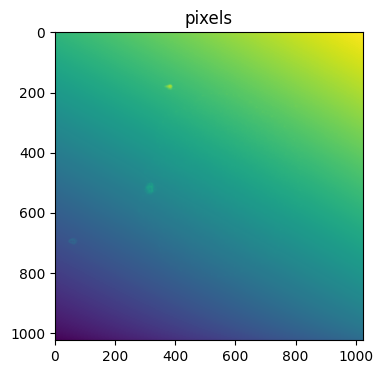

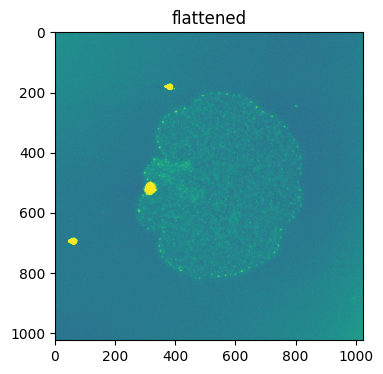

In [21]:
# file = Path('./Irregular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00026.spm') MISALIGNED FIBRIL
file = Path('./Irregular/20230118_KPN001_25mMMgCl2_Vac(2).0_00011.spm')
loadscans = LoadScans([file], 'Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

plot(filters.images['pixels'], title='pixels', zlimit=False, figsize=(4, 4))

if np.array_equal(filters.images['masked_tilt_removal'], filters.images['masked_median_flatten']):
    print("EQUAL")

flattened = filters.images['zero_average_background']
plot(flattened, title='flattened', figsize=(4, 4))

thresholds: defaultdict(None, {'upper': 1.8686453728637153})
[Fri, 24 Mar 2023 14:05:53] [INFO    ] [topostats] [None] : Masking (upper) Threshold: 1.8686453728637153


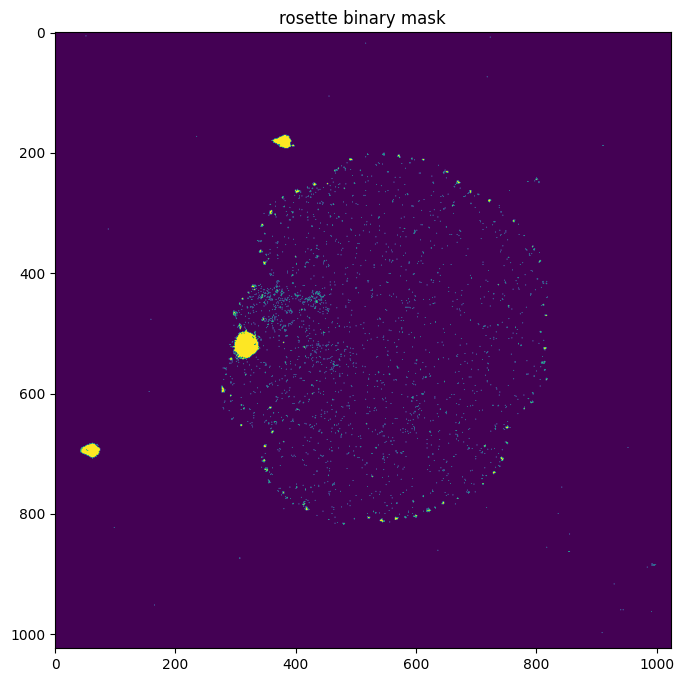

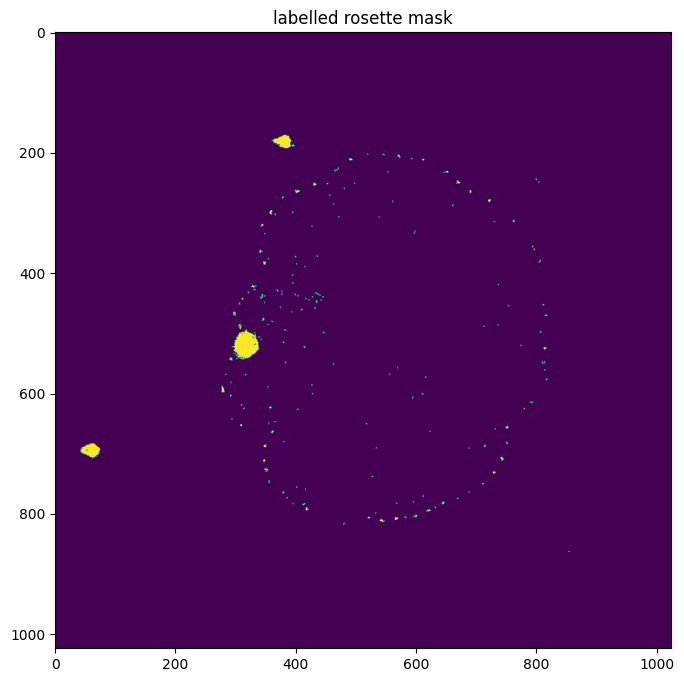

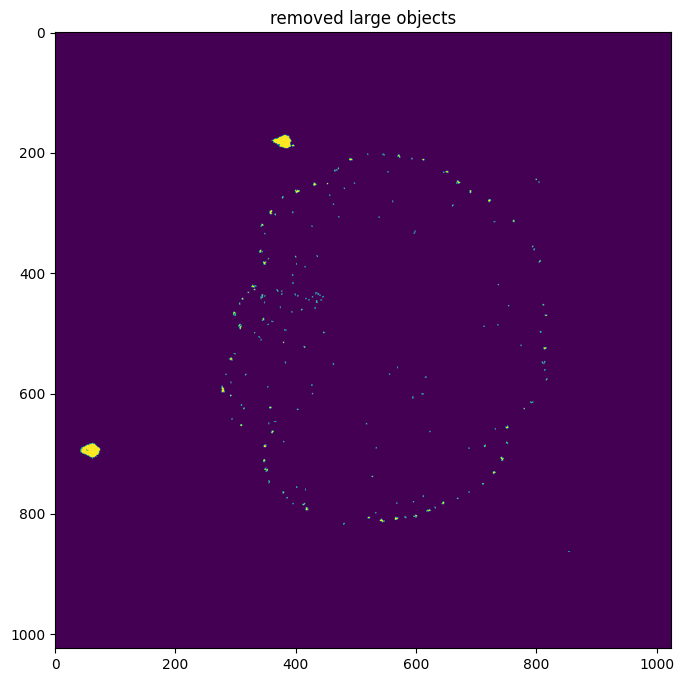

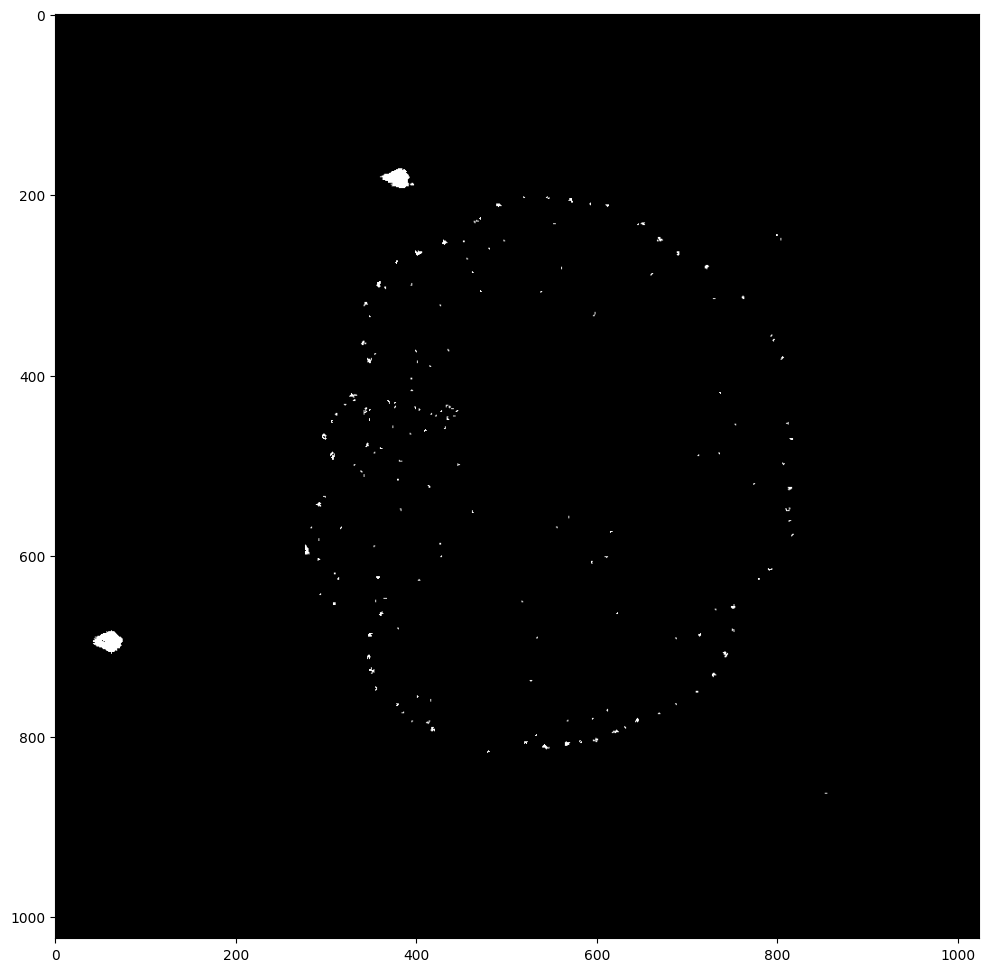

In [22]:
from skimage.morphology import remove_small_objects, label
from skimage.measure import regionprops
rosette_thresholds = topofilters.get_thresholds(
    flattened,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 2, 'lower': None}
)
# rosette_thresholds = topofilters.get_thresholds(
#     flattened,
#     threshold_method='absolute',
#     threshold_absolute={'upper': 3.75, 'lower': None}
# )
print(f'thresholds: {rosette_thresholds}')
rosette_mask = topofilters.get_mask(image=flattened, thresholds=rosette_thresholds)
plot(rosette_mask.astype(bool), title='rosette binary mask', zlimit=False)

# Remove small objects
removed_small_objects = remove_small_objects(rosette_mask, 3)
# plot(rosette_mask.astype(bool), title='removed small objects', zlimit=False)
# Remove large objects
labelled_rosette_mask = label(removed_small_objects)
plot(labelled_rosette_mask.astype(bool), title='labelled rosette mask', zlimit=False)
regions = regionprops(labelled_rosette_mask)
for props_index, props in enumerate(regions):
    if props.area > 750:
        labelled_rosette_mask[labelled_rosette_mask==props.label] = 0

plot(labelled_rosette_mask.astype(bool), title='removed large objects', zlimit=False)
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(labelled_rosette_mask.astype(bool), cmap='gray')


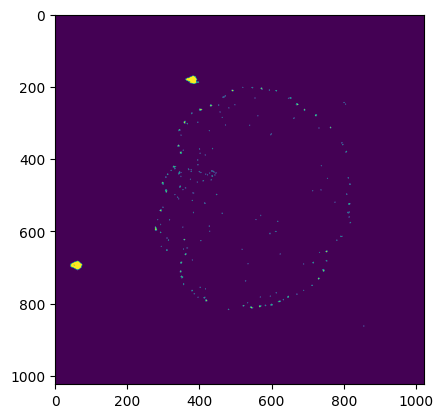

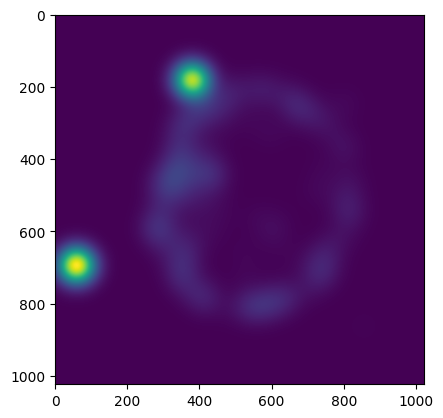

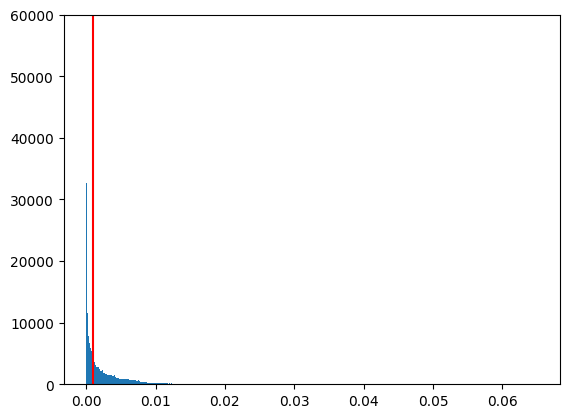

otsu threshold: 0.001


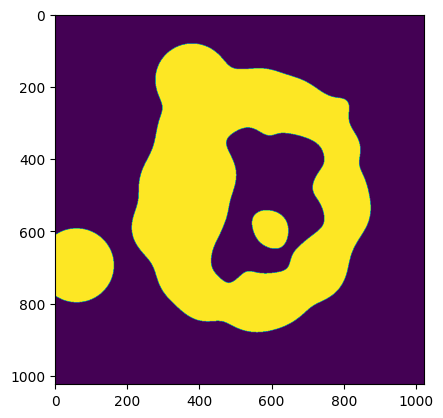

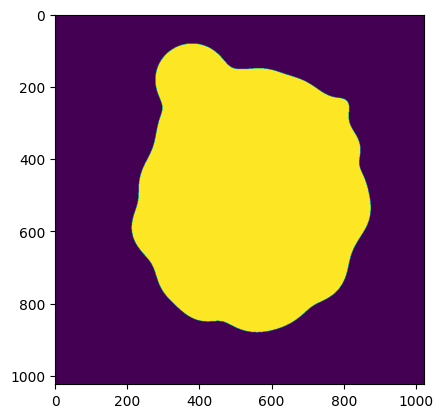

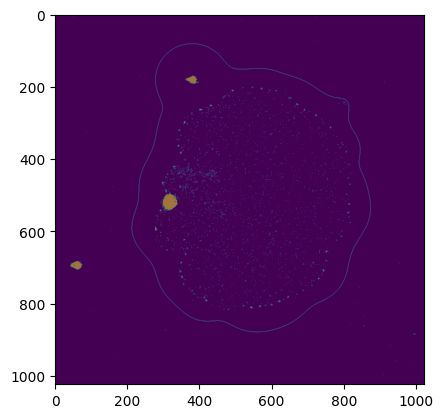

In [23]:
plt.imshow(labelled_rosette_mask.astype(bool))
plt.show()
gauss = gaussian(labelled_rosette_mask.astype(bool), sigma=35)
plt.imshow(gauss)
plt.show()



# threshold = threshold_otsu(gauss)
# threshold = 0.005
threshold = 0.001

fig, ax = plt.subplots()
ax.hist(gauss.flatten(), bins='auto')
ax.set_ylim(0, 60000)
plt.axvline(x=threshold, color='r')
plt.show()

print(f'otsu threshold: {threshold}')
thresholded = gauss > threshold
plt.imshow(thresholded)
plt.show()

labelled = label(thresholded)
region_props = regionprops(labelled)
max_size = max([props.area for props in region_props])
thresholded = remove_small_objects(thresholded, min_size=max_size-1)
thresholded = ndimage.binary_fill_holes(thresholded)
plt.imshow(thresholded)
plt.show()

# Add padding (needed for erosion)
padded = np.pad(thresholded, 1)
# Erode by 1 pixel
eroded = binary_erosion(padded)
# Remove padding
eroded = eroded[1:-1, 1:-1]

# Edges is equal to the difference between the
# original image and the eroded image.
edges = thresholded.astype(int) - eroded.astype(int)
plt.imshow(rosette_mask)
plt.imshow(edges, alpha=0.5)
plt.show()

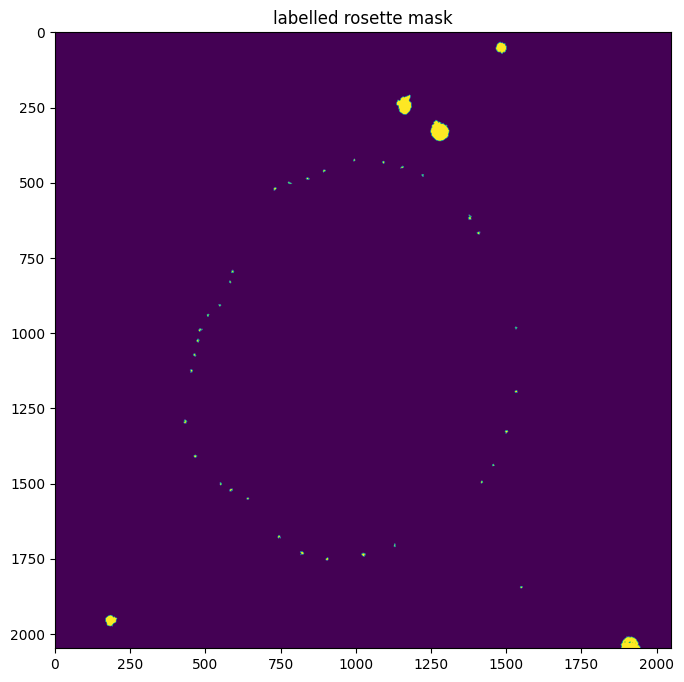

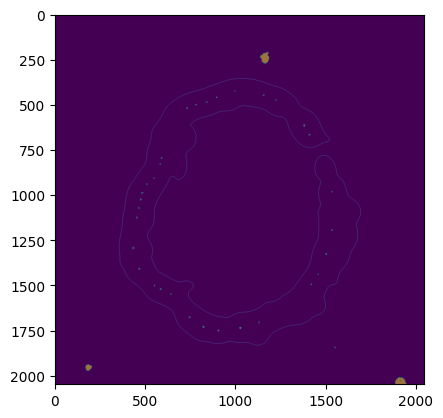

In [17]:
# Remove small objects
removed_small_objects = remove_small_objects(rosette_mask, 30)
# plot(rosette_mask.astype(bool), title='removed small objects', zlimit=False)
# Remove large objects
labelled_rosette_mask = label(removed_small_objects)
plot(labelled_rosette_mask.astype(bool), title='labelled rosette mask', zlimit=False)
for props_index, props in enumerate(regions):
    if props.area > 750:
        labelled_rosette_mask[labelled_rosette_mask==props.label] = 0

plt.imshow(edges)
plt.imshow(labelled_rosette_mask.astype(bool), alpha=0.5)
plt.show()



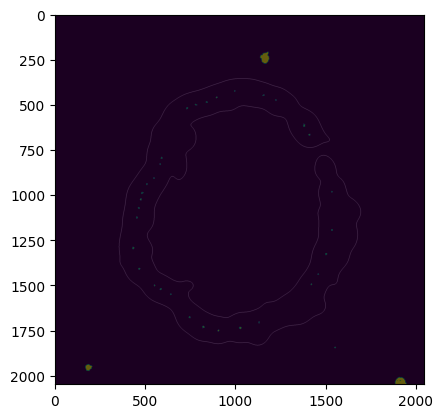

mean distance: 105.83522001061927
std dev distance: 108.6555633694541


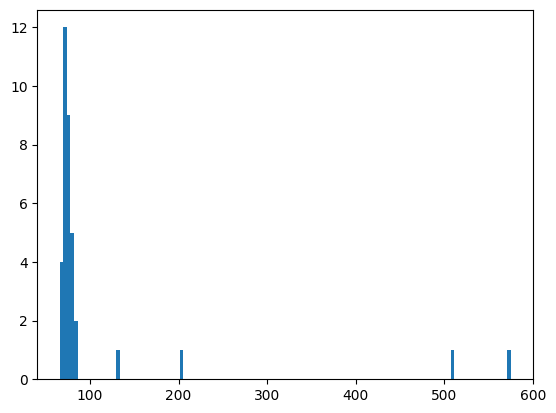

distance threshold: 51.50743832589222
points shape: (0,)


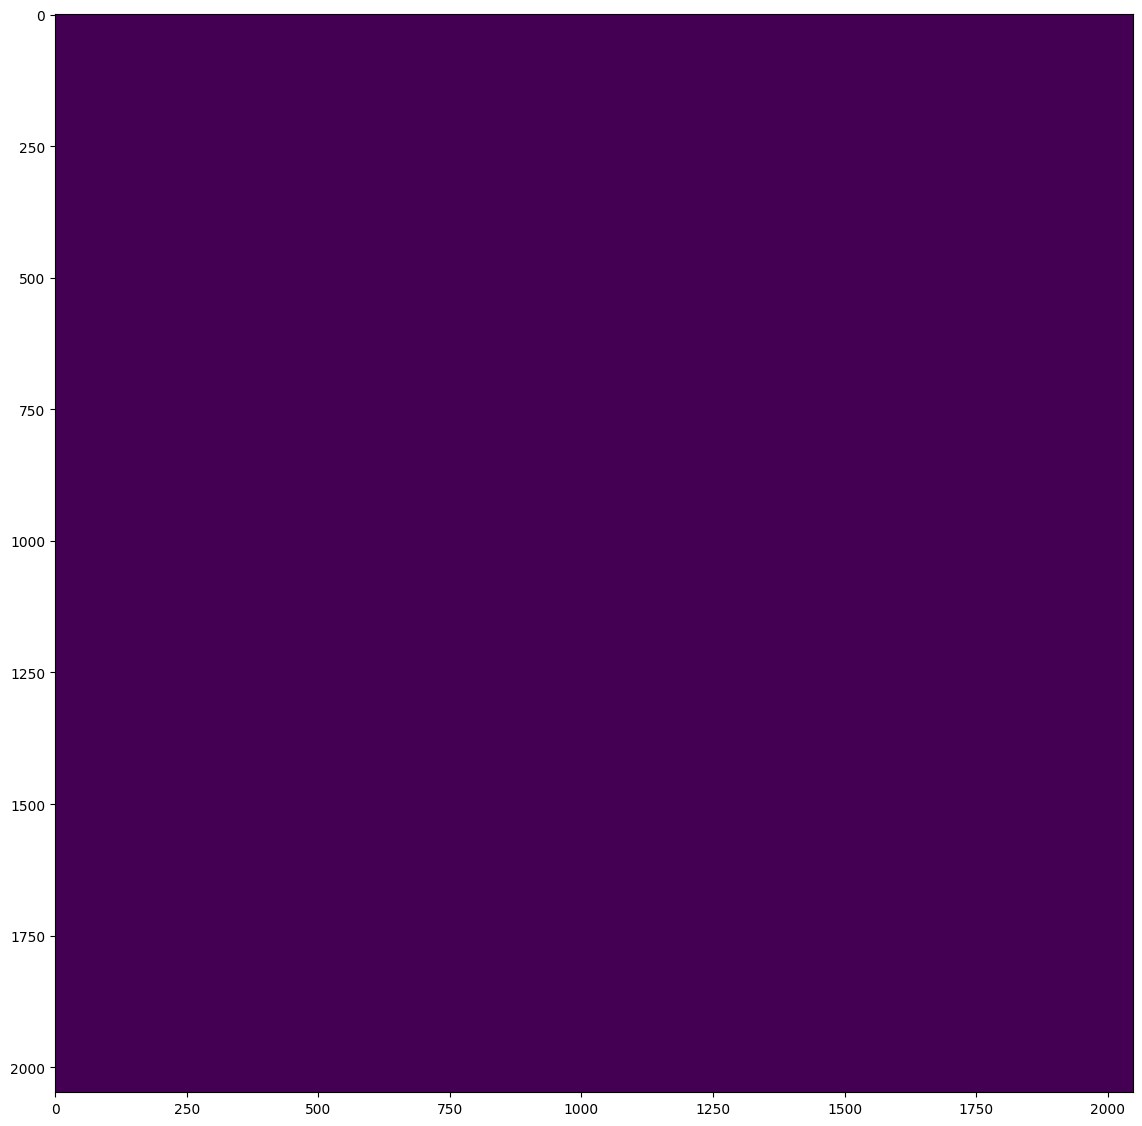

/opt/homebrew/Caskroom/miniforge/base/envs/new/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/new/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [18]:
plt.imshow(labelled_rosette_mask.astype(bool))
plt.imshow(edges, alpha=0.6, cmap='gray')
plt.show()

edge_positions = np.transpose(np.nonzero(edges))
region_props = regionprops(labelled_rosette_mask)
min_distances = np.zeros(len(region_props))
for props_index, props in enumerate(region_props):
    proplabel = props['label']
    centroid = np.array(props['centroid']).reshape(-1, 2)
    distances = np.linalg.norm(centroid - edge_positions, axis=1)
    min_distance = np.min(distances)
    min_distances[props_index] = min_distance

print(f'mean distance: {np.mean(min_distances)}')
print(f'std dev distance: {np.std(min_distances)}')
plt.hist(min_distances, bins='auto')
plt.show()
distance_threshold = np.mean(min_distances) - 0.5 * np.std(min_distances)
print(f'distance threshold: {distance_threshold}')

removed_too_far_points = labelled_rosette_mask.copy()
points = np.array([])
for props_index, props in enumerate(region_props):
    proplabel = props['label']
    centroid = np.array(props['centroid']).reshape(-1, 2)
    distances = np.linalg.norm(centroid - edge_positions, axis=1)
    min_distance = np.min(distances)
    if min_distance > distance_threshold:
        removed_too_far_points[removed_too_far_points == proplabel] = 0
    else:
        points = np.append(points, centroid).reshape(-1, 2)

points = np.array(points)
print(f'points shape: {points.shape}')

fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(removed_too_far_points.astype(bool))
plt.show()

# Find centroids of remaining points
labelled = label(removed_too_far_points)
regions = regionprops(labelled)
points = np.ndarray((len(regions), 2))
for props_index, props in enumerate(regions):
    points[props_index, :] = props.centroid

centroid = np.array([np.mean(points[:, 0]), np.mean(points[:, 1])])

# Function to find angle of point from centroid
def angle(point, centroid):
    dx, dy = point - centroid
    return (np.arctan2(dy, dx) + 2 * np.pi) % (2 * np.pi)

# Sort the points based on their angles around the centroid
sorted = points[np.argsort([angle(point, centroid) for point in points])]

xs = np.append(sorted[:, 1], sorted[0, 1])
ys = np.append(sorted[:, 0], sorted[0, 0])

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(flattened, vmin=-3, vmax=4)
ax.plot(xs, ys, 'k--')

plt.show()


In [16]:
def shoelace(points: np.ndarray):
    points = np.append(points, points[0]).reshape(-1, 2)
    area = 0
    for index in range(len(points)-1):
        matrix = points[index:index+2, :].T
        area += np.linalg.det(matrix)
    return np.round(area/2, 5)

In [17]:
def point_distances(points: np.ndarray):
    distance_matrix = distance.cdist(points, points, 'euclidean')
    distances = distance_matrix[np.triu_indices(points.shape[0], k=1)]
    return np.round(distances, 5)

In [18]:
def polygon_perimeter(points: np.ndarray):
    points = np.append(points, points[0]).reshape(-1, 2)
    perimeter = 0
    for i in range(len(points)-1):
        point1 = points[i, :]
        point2 = points[i+1, :]
        perimeter += np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
    return perimeter

In [19]:
def region_stats(labelled_image: np.ndarray, image: np.ndarray):

    region_props = regionprops(label_image=labelled_image)
    areas = np.zeros(len(region_props))
    volumes = np.zeros(len(region_props))
    for props_index, props in enumerate(region_props):
        areas[props_index] = props.area
        region_points = np.where(labelled_image == props.label)
        region_values = image[region_points]
        volume = np.sum(region_values)
        volumes[props_index] = volume

    return {
        'areas': areas,
        'volumes': volumes,
        'number_of_regions': len(region_props)
    }

number of nodes in perimeter: 65
total object area: 46.8365549657294 μm^2
perimeter: 25.23495694077266 μm
mean node area: 2780.760369142165 nm^2
mean node volume: 5906.46040686651 nm^3


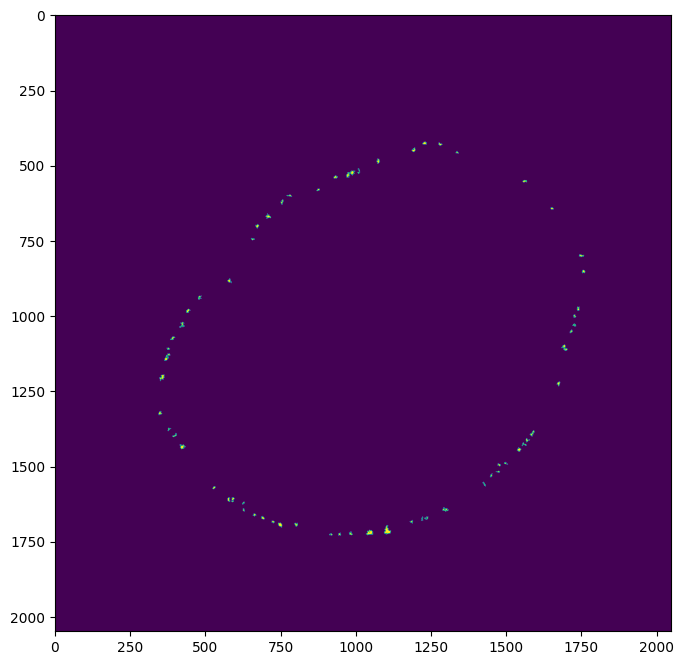

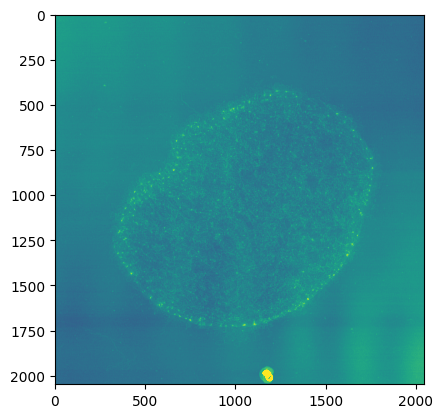

In [27]:

MICRON_SCALING_FACTOR = 0.001
P_TO_MICRON = p_to_nm * MICRON_SCALING_FACTOR

num_perimeter_nodes = sorted.shape[0]
print(f'number of nodes in perimeter: {num_perimeter_nodes}')
area = shoelace(sorted) * P_TO_MICRON**2
print(f'total object area: {area} μm^2')
perimeter = polygon_perimeter(sorted) * P_TO_MICRON
print(f'perimeter: {perimeter} μm')

# WATERSHED FOR ACCURATE AREA AND VOLUME STATS?

region_statistics = region_stats(labelled_image=labelled, image=flattened)
areas = region_statistics['areas'] * p_to_nm**2
print(f'mean node area: {np.mean(areas)} nm^2')
volumes = region_statistics['volumes'] * p_to_nm**2
print(f'mean node volume: {np.mean(volumes)} nm^3')

fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(labelled.astype(bool))
plt.show()
plt.imshow(flattened, vmin=-3, vmax=4)